Here is the problem we set out to day:
to estimate blood concentrations of estradol at all hours of day,
given a particular dosing regime and blood tests taken at a particular time.
I am honestly surprised noone has done this.
The intersection of trans folk and scientific computing is non-trivial.

To do this we are going to use probabablistic programming.
This is a great usecase for probablistic programming.
We have a ton of domain knowledge, but that domain knowledge has a few (not many) parameters we don't know, and we have only a little data.
Furthermore we would love to get a distribution over possible answers out of the system.


From [this blog post on Sublingual versus Oral Estrogen](http://transascity.org/sublingual-versus-oral-estrogen/) they approximated the estradoil function with a linear to the peak then an expodential decay.

> I plotted points from the sublingual estradiol curve, and came up with an estimate of the estradiol function from 1 hr to 24 hours as being `350.54*(HOURS^-0.907)`. From 0 to 1 hours, I estimated the estradiol level linearly, as `451*HOURS`.


I am today interested in the estradiol function for estradiol gel.
It's the same shape, so a similar strategy should apply.


Järvinen A, Granander M, Nykänen S, Laine T, Geurts P, Viitanen A (November 1997). "Steady-state pharmacokinetics of oestradiol gel in post-menopausal women: effects of application area and washing". Br J Obstet Gynaecol. 104 Suppl 16: 14–8. doi:10.111/j.1471-0528.1997.tb11562.x. PMID 9389778. S2CID 36677042.
give 3 curves for single dose.
Which are also available from Wikimedia Commons. Plots below:
![](https://upload.wikimedia.org/wikipedia/commons/1/19/Estradiol_levels_with_1_mg_per_day_transdermal_estradiol_gel_applied_to_different_amounts_of_area_in_postmenopausal_women.png)
These 3 curve in that study were from different application areas.
For our purposes that doesn't matter.
We instead can characterise them as 3 different realistic curves, which have some differences based on various causes (be they application area, location, physiology etc).
We will then estimate the parameters of those curves.

In [17]:
using Pkg: @pkg_str
pkg"activate --temp"
pkg"add Tables@1 Plots@1 Turing@0.21.12 MCMCChains@5.5 LsqFit@0.13.0 StatsPlots"

  Activating new project at `/tmp/jl_uZcUzU`
   Resolving package versions...
    Updating `/tmp/jl_uZcUzU/Project.toml`
  [2fda8390] + LsqFit v0.13.0
  [c7f686f2] + MCMCChains v5.5.0
  [91a5bcdd] + Plots v1.35.5
  [f3b207a7] + StatsPlots v0.15.4
  [bd369af6] + Tables v1.10.0
  [fce5fe82] + Turing v0.21.12
    Updating `/tmp/jl_uZcUzU/Manifest.toml`
  [621f4979] + AbstractFFTs v1.2.1
  [80f14c24] + AbstractMCMC v4.1.3
  [7a57a42e] + AbstractPPL v0.5.2
  [1520ce14] + AbstractTrees v0.4.3
  [79e6a3ab] + Adapt v3.4.0
  [0bf59076] + AdvancedHMC v0.3.6
  [5b7e9947] + AdvancedMH v0.6.8
  [576499cb] + AdvancedPS v0.3.8
  [b5ca4192] + AdvancedVI v0.1.6
  [dce04be8] + ArgCheck v2.3.0
  [7d9fca2a] + Arpack v0.5.3
  [30b0a656] + ArrayInterfaceCore v0.1.24
  [dd5226c6] + ArrayInterfaceStaticArraysCore v0.1.3
  [13072b0f] + AxisAlgorithms v1.0.1
  [39de3d68] + AxisArrays v0.4.6
  [198e06fe] + BangBang v0.3.37
  [9718e550] + Baselet v0.1.1
  [76274a88] + Bijectors v0.10.6
  [d1d4a3ce] + BitFlags v0.

  [f5851436] + FFTW_jll v3.3.10+0
  [a3f928ae] + Fontconfig_jll v2.13.93+0
  [d7e528f0] + FreeType2_jll v2.10.4+0
  [559328eb] + FriBidi_jll v1.0.10+0
  [0656b61e] + GLFW_jll v3.3.8+0
  [d2c73de3] + GR_jll v0.69.1+0
  [78b55507] + Gettext_jll v0.21.0+0
  [7746bdde] + Glib_jll v2.74.0+1
  [3b182d85] + Graphite2_jll v1.3.14+0
  [2e76f6c2] + HarfBuzz_jll v2.8.1+1
  [1d5cc7b8] + IntelOpenMP_jll v2018.0.3+2
  [aacddb02] + JpegTurbo_jll v2.1.2+0
  [c1c5ebd0] + LAME_jll v3.100.1+0
  [88015f11] + LERC_jll v3.0.0+1
  [dd4b983a] + LZO_jll v2.10.1+0
  [e9f186c6] + Libffi_jll v3.2.2+1
  [d4300ac3] + Libgcrypt_jll v1.8.7+0
  [7e76a0d4] + Libglvnd_jll v1.3.0+3
  [7add5ba3] + Libgpg_error_jll v1.42.0+0
  [94ce4f54] + Libiconv_jll v1.16.1+1
  [4b2f31a3] + Libmount_jll v2.35.0+0
  [89763e89] + Libtiff_jll v4.4.0+0
  [38a345b3] + Libuuid_jll v2.36.0+0
  [856f044c] + MKL_jll v2022.2.0+0
  [e7412a2a] + Ogg_jll v1.3.5+1
  [458c3c95] + OpenSSL_jll v1.1.17+0
  [efe28fd5] + OpenSpecFun_jll v0.5.5+0
  [91d4177

The curve defines the current blood concentration of E2 `c` at time `t` hours after application of the Estradiol gel.
It is decribed by 3 parameters:

 - `c_max`: the peak concentration.
 - `t_max`: the time it takes to reach peak concentration.
 - `halflife`: the time it takes for the concentration to half after reaching peak.

We express this as a higher order function of the 3 parameters, which returns a function of time.

In [18]:
function single_dose(c_max, halflife, t_max)
    function(t)
        if t < t_max
            c_max/t_max * t
        else
            c_max * 2^(-(t-t_max)/halflife)
        end
    end
end

single_dose (generic function with 1 method)

Let's see how we did.
I am going to plot the data from Järvinen et al against curves using my formula, best fit by my own inspection.
I am downshifting all the data from Järvinen et al by 25 pg/mL, as that data was from postmenopausal cis women, who produce about 25 pg/mL of estradoil on their own before you take into account HRT.
We only want to model the HRT component.

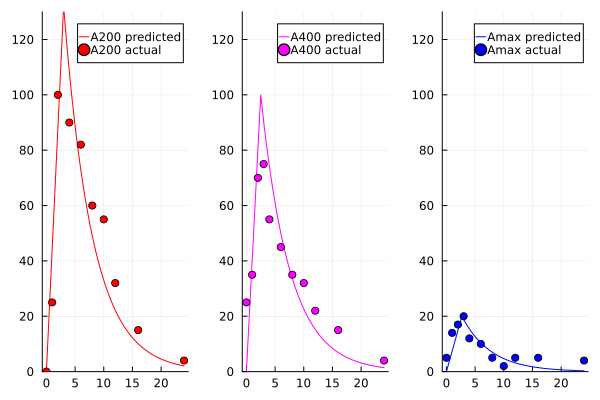

In [19]:
using Plots
plot(layout=(1,3))

plot!(
    0:0.1:24, single_dose(132, 3.5, 3),
    label="A200 predicted"; linecolor=:red, subplot=1, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red, subplot=1, yrange=(0,130),
)

plot!(
    single_dose(100, 3.5, 2.5),
    label="A400 predicted", linecolor=:magenta, subplot=2, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [25,35,70,75,55,45,35,32,22,15,4];
    label="A400 actual", markercolor=:magenta, subplot=2, yrange=(0,130),
)

plot!(
    single_dose(20, 3.5, 2.7),
    label="Amax predicted", linecolor=:blue, subplot=3, yrange=(0,130),
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [5,14,17,20,12,10,5,2,5,5,4];
    label="Amax actual", markercolor=:blue, subplot=3, yrange=(0,130),
)

By looking at these plots, it seems a pretty decent model.
Of-course with enough degrees of freedom, you can fit an elephant.
However we have 10 points and only 3 degrees of freedom, of which we only varied 2 of them across the 3 datasets.
So it seems like we are good.

It's broadly biologically plausable.
We expect a fast intial absorbsion, that should end at some point in few few hours -- 1-4 is various comments on how long to avoid showering on the packets depending on brand.
Since it is fast and short, it doesn't really matter what we model it with, so linear is fine.
Then we expect a tail off as it is consumed.
It makes sense for the rate of absorbsion to be related to the quanity remaining -- which suggests some expodential.
We expect this because the more estradol bumping around the higher the chance of one of them hitting a receptor and being consumed.
This might be nonsense, I am no systems biologist.



Now I just fit those curves by eye.
We can fine the the most likely parameters via least squares regression.
For this we can use [LsqFit.jl](https://github.com/JuliaNLSolvers/LsqFit.jl), normally I would use Optim.jl and write the least-squares problem out myself, and use [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) to solve it.
But LsqFit.jl's [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) is more appropriate.

c_max = 125.66238991436627
halflife = 4.883455201973709
t_max = 2.7924975536499423


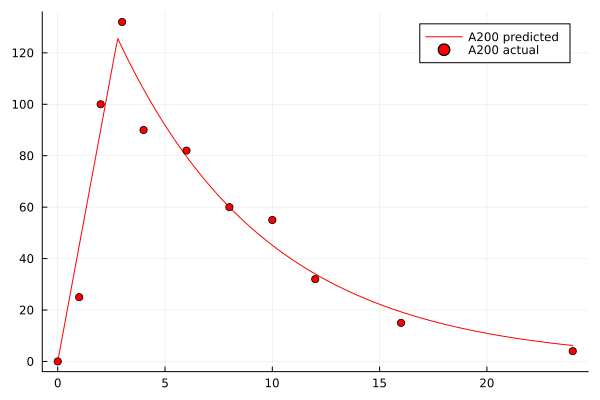

In [20]:
using LsqFit

fit = curve_fit(
    (t,p)->single_dose(p...).(t),
    [0,1,2,3,4,6,8,10,12,16,24],
    [0,25,100,132,90,82,60,55,32,15,4],
    [132, 3.5, 3]
)

c_max, halflife, t_max = fit.param
@show c_max halflife t_max

plot(
    0:0.1:24, single_dose(c_max, halflife, t_max),
    label="A200 predicted"; linecolor=:red,
)
scatter!(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red,
)

That is indeed a nice close fit.

This least square fit is a maximum likelyhood estimate (MLE), it is the curve which maximizes the likelihood of the observations.
Which is not quiet what we want, we want the maximum a posterior (MAP) estimate -- the curve which is most likely correct for these observations.
But really we are not after a single curve at all (MLE or MAP).
We are interested in distributions over possible curves, given the observations.
These tell use the possible realities that would explain what we are seeing.

To do this we will use probablistic programming.
In particular the [Turing.jl](https://turing.ml) library.
This is an ideal use case for probablistic programming.
We have a bunch of domain knowledge to give priors.
We only have a very small number of observations.
and we want to perform inference to determine distributions over a small number of parameters.

To begin with lets think about our priors.

 - `c_max` is somewhere between 0 and 500 pg/mL (ie. 0-1835pmol/L).
If your E2 is above that something is very wrong. For now let's not assume anything more and just go with a `Uniform` distribution. Though perhasp we could do something smarter hand select something that tailed off nicely towards the ends. e.g. `500Beta(1.01,1.01)`.
 - `t_max` is somewhere between 1 and 4 hours, we know this because the instruction say don't let anyone touch you for first hour (so its definately still absorbing then), and common wisdom is to not wash the area for at least 4 hours -- so it must be done but then. If we use a `4Beta(2,2)+1` distribution it has some push towards the center.
 - `halflife`, we know this has to be positive, since otherwise it would not decay. Being lognormal makes sense since it appears in an expontial. We would like it to have mode of `3.5` since that is what by eye we saw fit the curves all nicely (probably bad baysian cheating here) and because that means it is mostly all decayed by 24 hours -- it can't all that much higher usually since otherwise wouldn't need daily doses, nor that much lower since in that case would need multiple doses per day. To set the mode to 3.5 we use `LogNormal(log(3.5)+1, 1)`

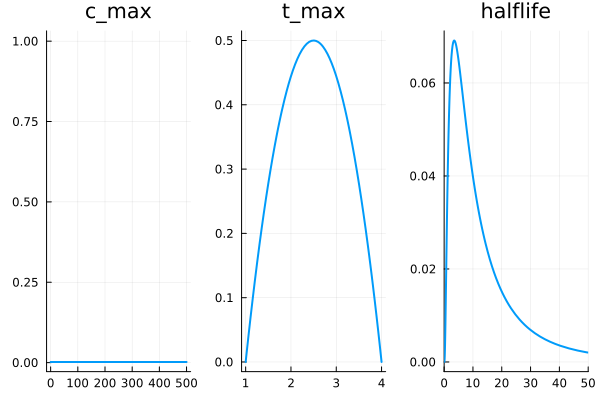

In [21]:
using Turing, StatsPlots
plot(layout=(1,3), legend=false, )
plot!(Uniform(0, 500), title="c_max", subplot=1, linewidth=2)
plot!(3Beta(2,2) + 1, title="t_max", subplot=2, linewidth=2)
plot!(LogNormal(log(3.5)+1, 1), title="halflife", xrange=(0,50), subplot=3, linewidth=2)

The other component we will want is an error term.
We want to express our observations of the concentration as being noisy samples from a distribution centered on the actual curve we are estimating.
So we need an error term which will allow some wiggle room about that curve, without throwing off the inference for the real parameters.
Our prior on this error term should be possitive with a peak at 0 and rapidly tailing off.
`Gamma(1, 1)` meets our requirement.

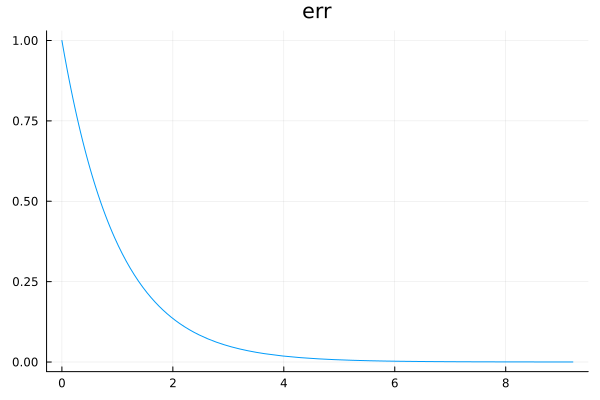

In [22]:
plot(Gamma(1,1), title="err", legend=false)

In [23]:
using Turing

@model function single_dose_model()
    c_max ~ Uniform(0, 500)
    t_max ~ 3Beta(2,2) + 1
    halflife ~ LogNormal(log(3.5)+1, 1)
    
    dose_f = single_dose(c_max, halflife, t_max)  

    err ~ Gamma(1, 1)
    
    # There is probably a smarter way to do this, but we want to allow observations at different hours
    c1 ~ Normal(dose_f(1), err)
    c2 ~ Normal(dose_f(2), err)
    c3 ~ Normal(dose_f(3), err)
    c4 ~ Normal(dose_f(4), err)
    c6 ~ Normal(dose_f(6), err)
    c8 ~ Normal(dose_f(8), err)
    c10 ~ Normal(dose_f(10), err)
    c12 ~ Normal(dose_f(12), err)
    c16 ~ Normal(dose_f(16), err)
    c24 ~ Normal(dose_f(24), err)
    
    return (c1, c2, c3, c4, c6, c8, c10, c12, c16, c24)
end


single_dose_model (generic function with 2 methods)

In [24]:
model = single_dose_model() | (;c1=25,c2=100,c3=132,c4=90,c6=82,c8=60,c10=55,c12=32,c16=15,c24=4)
chain=sample(model, NUTS(), 4_000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (4000×16×1 Array{Float64, 3}):

Iterations        = 1001:1:5000
Number of chains  = 1
Samples per chain = 4000
Wall duration     = 2.76 seconds
Compute duration  = 2.76 seconds
parameters        = c_max, t_max, halflife, err
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat   ⋯
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64   ⋯

       c_max   124.9619    5.8463     0.0924    0.1097   2857.5296    0.9999   ⋯
       t_max     2.7660    0.1798     0.0028    0.0031   3163.4584    1.0002   ⋯
    halflife     5.0017    0.5705     0.0090    0.0108   2491.7787    0.9999   ⋯
         err     8.5164    1.4032     0.0222    0.0309   2430.5400    1.0001   ⋯
                                              

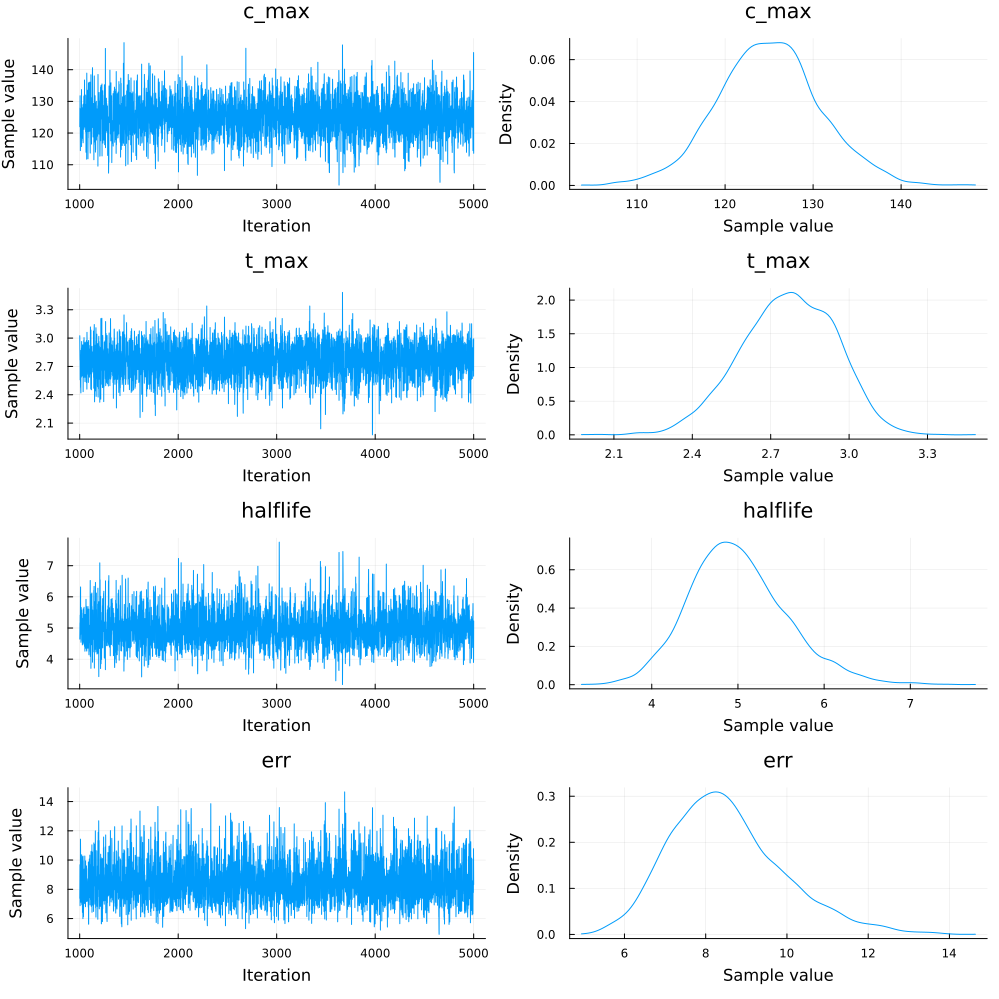

In [25]:
using StatsPlots
plot(chain)

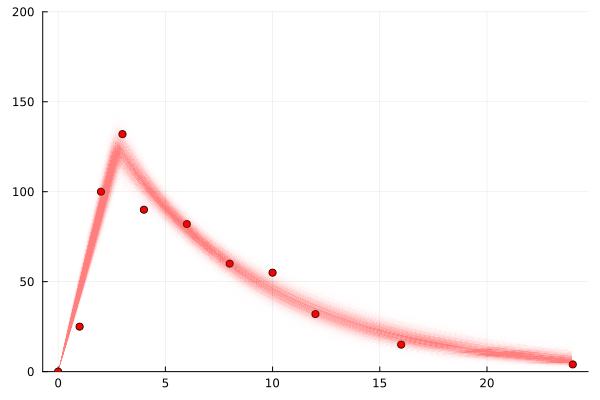

In [26]:
using Tables

gr(fmt=:png)  # make sure not to plot svg or will crash browser
scatter(
    [0,1,2,3,4,6,8,10,12,16,24], [0,25,100,132,90,82,60,55,32,15,4],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=0.5,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

We see this nice kinda clear and fairly small range of values for the parameters: `c_max`, `t_max`, `halflife`.
The error term, `err`, is quite large

Now that we have shown we can do inference to that find distributions over parameters that fit the curve lets get on to a more realistic task.
Noone gets blood tests every few hours outside of a experiment data gathering exercise.
The most frequent blood tests i have heard of is every 2 weeks, and most are more like every 3-6 months.
So what we are really interested in is inferring what could be happening with blood levels from a single observation.

The practical case is applying in the morning before work, and getting a blood test toward the end of the work day just before the phlebotomist closes up.
So we will look at the sample for `c8`, the blood concentration 8 hours after dosing.
And we want to see a distribution over all possible estrogen level functions that would lead to that observation.
This is what it is actually all about.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing/

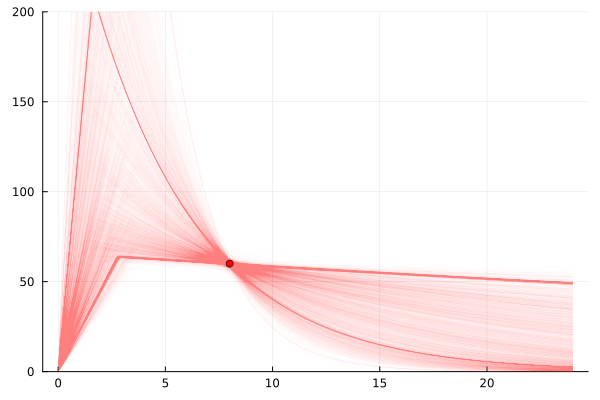

In [27]:
model = single_dose_model() | (;c8=60)
chain=sample(model, NUTS(), 4_000)

scatter(
    [8], [60],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

So that's actually really informative.
There are a range of possible explinations.
From a very small `t_max` and a large `c_max` meaning it peaked eary and has tailed off a lot,
to the more likely ones which look more like the kind of curves we were seeing based on the experimental data with more frequent measurements.
This is really cool.

We can add more observation points and cut-down the number of realitities we might be in.
This realistically is actually a practical thing to do.
Each point is a blood test -- in London trans folk can get them free in the evenings a few days a week at [56T Dean St](https://www.dean.st/trans-non-binary/) or [ClinQ](https://cliniq.org.uk/cliniq-kings-south-london/), or  some NHS GPs will also do them for trans folk, many (including mine) will not because the NHS is systematically transphobic and doctors think trans folk are too complex for them. So to get a few in one day you would need to pay privately about £50. Which is nice that we know exactly how much each observcation costs.

So we can simulate adding another obsercation.
You can see if we add a reading of 60 at 8 hours after application we break the universe into two possible sets of explination. One set where the 3 hour reading is while it is still rising, and one set where it is falling.

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = 

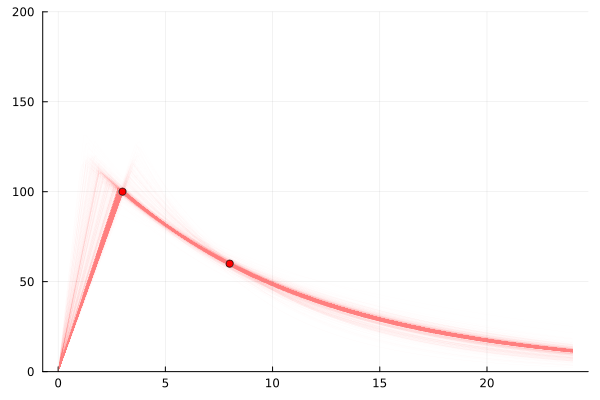

In [28]:
model = single_dose_model() | (;c3=100, c8=60)
chain=sample(model, NUTS(), 4_000)

scatter(
    [3, 8], [100, 60],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


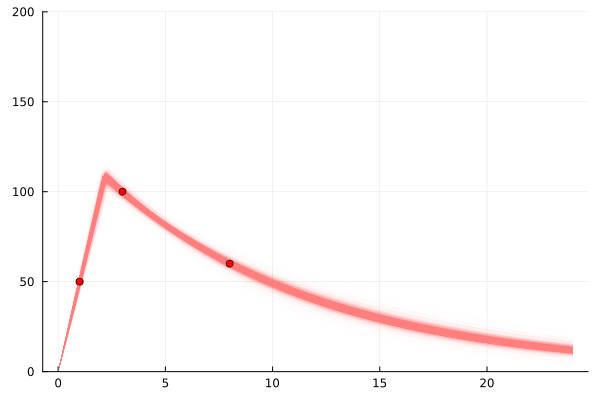

In [29]:
model = single_dose_model() | (;c3=100, c8=60, c1=50)
chain=sample(model, NUTS(), 4_000)

scatter(
    [3, 8, 1], [100, 60, 50],
    label="A200 actual", markercolor=:red,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:red, yrange=(0,200),
    )
end
plot!()

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing

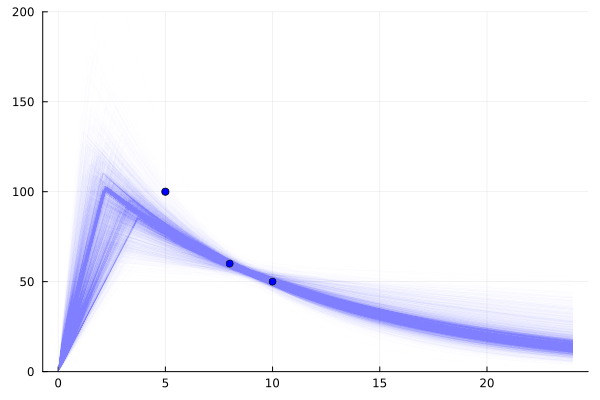

In [34]:
model = single_dose_model() | (;c5=100, c8=60, c10=50)
chain=sample(model, NUTS(), 4_000)

scatter(
    [5, 8, 10], [100, 60, 50],
    label="A200 actual", markercolor=:blue,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:blue, yrange=(0,200),
    )
end
plot!()

It is worth noting that while these 3 points do lead to a relatively small set of possible worlds, this is not always the case.
Unlike for fitting a multivariate linear (or a number of other curves) one point per degree of freedom is not enough.
For example if all points could be during the first piecewise segment, we know even less about the state of the world than if we had 1 point in the tailing off segment (especially if those points suggest a large error in the readings `err`)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/oxinabox/.julia/packages/AdvancedHMC/iWHPQ/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /home/oxinabox/.julia/packages/Turing/szPqN/src/inference/hmc.jl:191
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


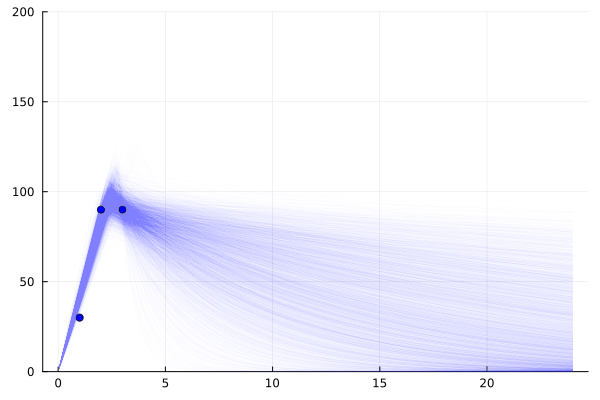

In [30]:
model = single_dose_model() | (;c1=30, c2=90, c3=90)
chain=sample(model, NUTS(), 4_000)

scatter(
    [1,2,3], [30, 90, 90],
    label="A200 actual", markercolor=:blue,
    legend=false
)

for samp in rowtable(chain)
    f = single_dose(samp.c_max, samp.halflife, samp.t_max)
    plot!(
        0:0.1:24, f,
        linewidth=1,
        linealpha=0.005, linecolor=:blue, yrange=(0,200),
    )
end
plot!()

This is just a first look at this topic.
I imagine I might return to it again in the future.
Here are some extra things we might like to look at:

 - Determining optimal times to test: as discussed 3 readings will not always capture the curve, different times may be more informative than others, especially when we consider the error level vs the signal level.
 - Average levels: the distribution of average level is likely fairly collapsed -- multiple different sets of parameter values can lead to same average level. I suspect average level is relevent to some biological functions.
 - Multi-day: Since Estogen doesn't hit zero at 24 hours can model across days. Can also include a term for variation in when it was applied in the day since people are not that consistent. Multiday is crucial for making the model realistic
 - Dose changes: extending beyond multiday, people change there does, and we know higher dose leads to higher levels so we can insert that prior knowledge.
 
Probablistic programming is a cool technique for working on pharmodynics.
It lets us handle the fact that we have many unknowns about people's individual biology, while still narrowing down a possible set of worlds they might live in.

In [31]:
]st

      Status `/tmp/jl_uZcUzU/Project.toml`
  [2fda8390] LsqFit v0.13.0
  [c7f686f2] MCMCChains v5.5.0
  [91a5bcdd] Plots v1.35.5
  [f3b207a7] StatsPlots v0.15.4
  [bd369af6] Tables v1.10.0
  [fce5fe82] Turing v0.21.12
